<a href="https://colab.research.google.com/github/acrossariver/acrossariver.github.io/blob/master/%E8%87%AA%E4%BD%9C%E3%82%B9%E3%82%AF%E3%83%AA%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#共通コード

In [ ]:
###共通コード###
###2024-09-15Start###

#Expenditureコード

In [ ]:
###Expenditureコード###
###2024-08-26Start###
###2024-08-30End Ver.01###

from warnings import resetwarnings
from re import I

# 認証のためのコード
#参考：https://qiita.com/FrozenVoice/items/d9cc04b3f63f4b2d49c2
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet ='[https://docs.google.com/spreadsheets/d/1C2Ryfv9R1NLwzb6JK-Tv4PtEKKJFCNi7-DOuom5DPc0/edit?gid=122499081#gid=122499081]'
###公開用のスプレッドシートのファイルURL https://docs.google.com/spreadsheets/d/1KNf5wBL09eXU4ysi7OEMfrivoiOxdCUUP_mZ7SV-u94/edit?usp=sharing

#worksheetの2024_houseaccountを選ぶ　番号では(0)となる
worksheet = gc.open_by_url(worksheet).get_worksheet(0)

import pandas as pd

#[1:]で２行目からをデータ、[0]で１行目をindexに指定している。
#参考：https://note.com/kohaku935/n/nc13bcd11632d
df = pd.DataFrame(worksheet.get_all_values()[1:], columns=worksheet.get_all_values()[0])
df["Date"] = pd.to_datetime(df["Date"])

#DateのSeriesから年月のSeriesを作成 object型に変化している！
df = df.rename({"Date":"YearMonth"},axis="columns")
#Date_series =df["YearMonth"].dt.strftime("%Y年%m月")
Date_series =df["YearMonth"].dt.strftime("%Y-%m")
#print(YearMonth_series)
#LeftItemのSeriesを作成
LItem_series = df["LeftItem"]
#print(LItem_series)
#AmountのSeriesを作成
df["Amount"] = df["Amount"].str.replace(',','')
#Amount_series = df["Amount"].astype(int)
Amount_series = pd.to_numeric(df["Amount"], errors='coerce').fillna(0).astype(int)
#print(Amount_series)
#RightItemのSeriesを作成
RItem_series = df["RightItem"]
#RemarkのSeriesを作成
Remark_series = df["Remark"]
#各Seriesを連結させてDataFrameを作成
df_alldata = pd.concat([LItem_series,Date_series,Amount_series,RItem_series,Remark_series],axis=1)
#print(df)

#df_alldataを使って、df_expenditureデータの作成
df = df_alldata

#不要な行を削除
##LeftItemのうちで不要な科目のリストを除外
##参考：https://nomuotorinko.com/python_isin/
##参考：https://monaledge.com/article/347
#左方の除外リスト
exclude_left = ["Hcash","Ycash","Osav","Rsav","Nsav","Fsav","Nyub","Hyub","Point","Stock","Svalu","Build","Land","Vehi","Rcard","Acard","Mcard","Rassets","Rearning","Vdif","MS","YM","SI","DI","CG","BN","OI"]
#~isinを使って除外する
df = df[~df["LeftItem"].isin(exclude_left)]

#大科目"Unit"に分類
##控除
NonconEx = ("cded","ftax","ctax")
df.loc[df["LeftItem"].isin(NonconEx),"Unit"] = "1.NonconEx"
##固定費
FixedEx = ("rent","tel","prov","nhk","sch","edu","yins","nins","hins","water","gas","elec","kero","care")
df.loc[df["LeftItem"].isin(FixedEx),"Unit"] = "2.FixedEx"
##変動費
VariableEx = ["food","resta","health","dneeds","gasoline","vment","child","culture","social","cloth","study","job","hmade","garden","petty"]
df.loc[df["LeftItem"].isin(VariableEx),"Unit"] = "3.VariableEx"
##特別支出
ExtraEx = ["scost","icost","closs","ecost"]
df.loc[df["LeftItem"].isin(ExtraEx),"Unit"] = "4.ExtraEx"
#print(df_Extra)


#pivot_tableを使ってインデックスのLeftItemごとの年月日の合計を出す
df_pivot = df.pivot_table(index=["Unit","LeftItem"], columns="YearMonth", values=["Amount"],aggfunc=sum)
#df_pivot = df.pivot_table(index="Date",columns="LeftItem", values=["Amount"],aggfunc=sum)
df_pivot = df_pivot["Amount"].fillna(0)
df_pivot = pd.DataFrame(df_pivot).astype(int)
##fillna(0)をすると小数点以下がつくので、整数(int)に変換
df2 = df_pivot

#インデックスのUnitでソート
df2 = df2.sort_index(level='Unit')

#２つのインデックス、"LeftItem"と"Unit"を列に変換
df2.reset_index(inplace= True)
df2 = df2.rename(columns={'index': 'Items'})

#print(df2)

#LeftItemごとの平均値を求める
df2["Average"] = df2.iloc[:,2:].mean(axis=1).astype(int)

# Averageの列を3列目に移動
target_col = "Average"
df_target = df2[target_col]
##入れ替え対称の列を削除
df2 = df2.drop(target_col, axis=1)
##任意の場所に対象の列を挿入
df2.insert(2, target_col, df_target)
#Unit列を優先し、Average列で昇順にソート
df2 = df2.sort_values(["Unit","Average"], ascending=[True,False])

###各Unitの合計・総合計が含まれていないDataFrame
###############
df_nototal = df2 ##
###############


#DataFrameを切り分け、各Unitの最終行に合計を入れ、総合計も入れる
##控除
df2_Noncon = df2[df2["Unit"].isin(["1.NonconEx"])]
df2_NonconAll = pd.concat([df2_Noncon,pd.DataFrame(df2_Noncon.sum(numeric_only=True)).T])
##固定費
df2_Fixed = df2[df2["Unit"].isin(["2.FixedEx"])]
df2_FixedAll = pd.concat([df2_Fixed,pd.DataFrame(df2_Fixed.sum(numeric_only=True)).T])
##変動費
df2_Variable = df2[df2["Unit"].isin(["3.VariableEx"])]
df2_VariableAll = pd.concat([df2_Variable,pd.DataFrame(df2_Variable.sum(numeric_only=True)).T])
##特別支出
df2_Extra = df2[df2["Unit"].isin(["4.ExtraEx"])]
df2_ExtraAll = pd.concat([df2_Extra,pd.DataFrame(df2_Extra.sum(numeric_only=True)).T])
##総合計のため上で作ったdf2をもってきて、合計する
df2_sum = df2.sum(numeric_only=True)
##合計を含んだ各Unitをつなぎ合わせる
df2_alldata = pd.concat([df2_NonconAll,df2_FixedAll,df2_VariableAll,df2_ExtraAll],axis=0)
###最後に総合計もつなぎ合わせ、すべてつなぎ合わせたら終わり！！！
df2_alldata = pd.concat([df2_alldata,pd.DataFrame(df2_sum).T])
#print(df2_alldata)

###各Unit毎の合計も含んだデータ
df_expenditure = df2_alldata ##
###############################


#スプレッドシートに書き出し
from gspread_dataframe import set_with_dataframe
expenditure ='[https://docs.google.com/spreadsheets/d/1H0HJt8drocUbmEelecu3Hkr2shc0Bsbl8CGGJNqsFSo/edit?gid=616959466#gid=616959466]'
worksheet = gc.open_by_url(expenditure).get_worksheet(0)
set_with_dataframe(worksheet, df_expenditure)

<ipython-input-1-0eedbd2e1a03>:82: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_pivot = df.pivot_table(index=["Unit","LeftItem"], columns="YearMonth", values=["Amount"],aggfunc=sum)


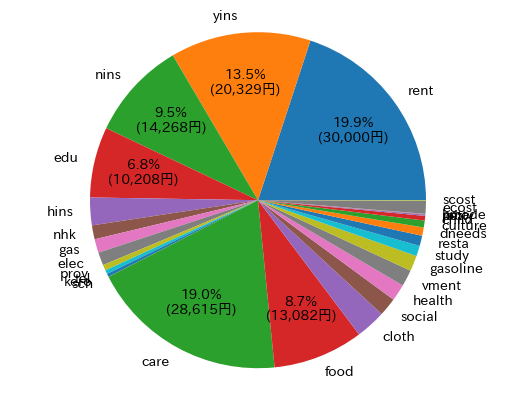

20329
4337
150391


IndexError: index 36 is out of bounds for axis 0 with size 34

In [ ]:
###ExpenditureGraphコード###
###2024-09-01END Ver.01###

#Expenditureコードで生成されたDataFrame（df_expenditure）を持ってくる
df1 = df_expenditure
df2 = df_nototal
#df1.info()
#df2.info()

!pip install japanize_matplotlib



import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

#勘定科目ごとの平均値の円グラフ

#割合だけでなく数値も表示する関数
#参考：https://python-yutaka.com/matplotlib_pie_graph_display_abs_value/
def abs_func(pct, abs_values):
    absolute = int(np.round(pct/100.*np.sum(abs_values)))
    return "{:.1f}%\n({:,}円)".format(pct, absolute)

labels = df2["LeftItem"]
sizes = df2["Average"]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct=lambda pct: abs_func(pct, sizes) if pct>=5 else '',pctdistance=0.7)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


print(df1.iloc[2,2])
print(df1.iloc[16,2])
print(df1.iloc[33,2])
print(df1.iloc[36,2])

#Uitごとの平均値の円グラフ



labels = ["非消費支出","固定費","変動費","特別支出"]
sizes = [df1.iloc[2,2],df1.iloc[16,2],df1.iloc[33,2],df1.iloc[36,2]]
fig, ax = plt.subplots()
#ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.pie(sizes, autopct=lambda pct: abs_func(pct, sizes) if pct>=5 else '',pctdistance=0.7, labels=labels)

ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Profit & Lossコード

In [ ]:
###Profit&Lossコード###
###2024-09-15Start###
###2024-09-16END Ver.01###

from warnings import resetwarnings
from re import I

# 認証のためのコード
#参考：https://qiita.com/FrozenVoice/items/d9cc04b3f63f4b2d49c2
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)
###houseaccount_sheet
worksheet ='[https://docs.google.com/spreadsheets/d/1VUsSmDP9LEfcMhk8xDhVXNLCTxnN0AV5myQKCLleeVw/edit?gid=122499081#gid=122499081]'


#worksheetの2024_houseaccountを選ぶ　番号では(0)となる
worksheet = gc.open_by_url(worksheet).get_worksheet(0)

import pandas as pd

#[1:]で２行目からをデータ、[0]で１行目をindexに指定している。
#参考：https://note.com/kohaku935/n/nc13bcd11632d
ha_df = pd.DataFrame(worksheet.get_all_values()[1:], columns=worksheet.get_all_values()[0])

###income_sheet
worksheet = '[https://docs.google.com/spreadsheets/d/1N6rvFklWJqzIVhXslx34vGmFzTskH0O1fdug_OlZaYE/edit?gid=603402171#gid=603402171]'

#worksheetの2024_houseaccountを選ぶ　番号では(0)となる
worksheet = gc.open_by_url(worksheet).get_worksheet(0)
is_df = pd.DataFrame(worksheet.get_all_values()[1:], columns=worksheet.get_all_values()[0])

#二つのdataframeを連結
df = pd.concat([ha_df, is_df])
#print(df)


#データフレームの型を変更する。Dateはdatetime64[ns]、Amounはint64
df["Date"] = pd.to_datetime(df["Date"])
df["Amount"] = pd.to_numeric(df["Amount"], errors='coerce').fillna(0).astype(int)

df.info()

#集計する日付をinputで指定する
#start =input()
start = "2024-01-01"
#end = input()
end = "2024-09-30"
df = df.loc[(df['Date'] >= start) & (df['Date'] <= end)]
print(df)

###ここまででProfit&Lossで使用するデータフレームが出来上がる。

#不要な項目を削除

#不要な行を削除
#左方の除外リスト
exclude_left = ["Nsav","Nyub","Hyub","Point","Stock","Svalu","Build","Land","Vehi","Rcard","Acard","Mcard","Rassets","Rearning","Vdif","MS","YM","SI","DI","CG","BN","OI"]
#~isinを使って除外する
df = df[~df["LeftItem"].isin(exclude_left)]

#DateのSeriesから年月のSeriesを作成 object型に変化している！
df = df.rename({"Date":"YearMonth"},axis="columns")
#Date_series =df["YearMonth"].dt.strftime("%Y年%m月")
Date_series =df["YearMonth"].dt.strftime("%Y-%m")
#print(YearMonth_series)
#LeftItemのSeriesを作成
LItem_series = df["LeftItem"]
#print(LItem_series)
#AmountのSeriesを作成
#df["Amount"] = df["Amount"].str.replace(',','')
#Amount_series = df["Amount"].astype(int)
Amount_series = pd.to_numeric(df["Amount"], errors='coerce').fillna(0).astype(int)
#print(Amount_series)
#RightItemのSeriesを作成
RItem_series = df["RightItem"]
#RemarkのSeriesを作成
Remark_series = df["Remark"]
#各Seriesを連結させてDataFrameを作成
df_alldata = pd.concat([LItem_series,Date_series,Amount_series,RItem_series,Remark_series],axis=1)
#df_alldataをdfに
df = df_alldata

gaso = df.loc[(df['LeftItem'] == 'gasoline') & (df['RightItem'] == 'Ycash')]

gaso["LeftItem"].mask(gaso["LeftItem"] == "gasoline", "gasoline2",  inplace=True)
df_all = pd.concat([df,gaso])
print(gaso)
df = df_all

#大科目"Unit"に分類
##収入 Income
Income = ("MS","BN","YM")
df.loc[df["RightItem"].isin(Income),"Unit"] = "01.Income"
###コストコカードのガソリン代分の
gaso = ["gasoline2"]

#print(gaso)
df.loc[df["LeftItem"].isin(gaso),"Unit"] = "01.Income"
#df.loc[df["LeftItem"].isin(gaso),"Unit"] = "01.Income"
##手取 NetIncome
##ここにはIncome
###左方gasolineをコピーして追加、追加分を"01.Income"
###!!!!いずれつくる!!!!####
##非消費支出 Non-consumption Expenses
NonconEx = ("cded","ftax","ctax")
df.loc[df["LeftItem"].isin(NonconEx),"Unit"] = "02.NonconEx"
##手取 NetIncome
##ここにはIncome-NonconExの値が入る "03.NetIncome"
##変動費 Variable Expenses
VariableEx = ["food","resta","health","dneeds","gasoline","vment","child","culture","social","cloth","study","job","hmade","garden","care","petty","pocket"]
df.loc[df["LeftItem"].isin(VariableEx),"Unit"] = "04.VariableEx"
##粗利 Gross Profit
##ここにはNetIncome - VariableExpensesの値が入る "05.GrossPr"
##固定費
FixedEx = ("rent","tel","prov","nhk","sch","edu","yins","nins","hins","water","gas","elec","kero")
df.loc[df["LeftItem"].isin(FixedEx),"Unit"] = "06.FixedEx"
##営業利益 Net Profit
##ここにはGross Profit - FixedExpensesの値が入る "07.NetPr"
##特別利益
ExtraIn = ["SI","DI","CG","OI"]
df.loc[df["RightItem"].isin(ExtraIn),"Unit"] = "08.ExtraIn"
##特別支出
ExtraEx = ["scost","icost","closs","ecost"]
df.loc[df["LeftItem"].isin(ExtraEx),"Unit"] = "09.ExtraEx"
##経常利益
##ここにはNet Profit + Exttra Income - ExtraExpensesの値が入る　"10.OrdinaryPr"


#pivot_tableを使ってインデックスのLeftItemごとの年月日の合計を出す
df_pivot = df.pivot_table(index=["Unit"], columns="YearMonth", values=["Amount"],aggfunc=sum)
#df_pivot = df.pivot_table(index="Date",columns="LeftItem", values=["Amount"],aggfunc=sum)
df_pivot = df_pivot["Amount"].fillna(0)
df_pivot = pd.DataFrame(df_pivot).astype(int)
##fillna(0)をすると小数点以下がつくので、整数(int)に変換
#print(df_pivot)

#インデックスのUnitでソート
df_pivot = df_pivot.sort_index(level='Unit')

#２つのインデックス、"LeftItem"と"Unit"を列に変換
df_pivot.reset_index(inplace= True)
df_pivot = df_pivot.rename(columns={'index': 'Items'})
#print(df_pivot)

#LeftItemごとの平均値を求める
df_pivot["Average"] = df_pivot.iloc[:,2:].mean(axis=1).astype(int)

#合計値を求める
df_pivot["Total"] = df_pivot.iloc[:,2:].sum(axis=1).astype(int)


# Averageの列を3列目に移動
target_col = "Average"
df_target = df_pivot[target_col]
##入れ替え対称の列を削除
df_pivot = df_pivot.drop(target_col, axis=1)
##任意の場所に対象の列を挿入
df_pivot.insert(1, target_col, df_target)
#Unit列を優先し、Average列で昇順にソート
df_pivot = df_pivot.sort_values(["Unit","Average"], ascending=[True,False])

# Totalの列を2列目に移動
target_col = "Total"
df_target = df_pivot[target_col]
##入れ替え対称の列を削除
df_pivot = df_pivot.drop(target_col, axis=1)
##任意の場所に対象の列を挿入
df_pivot.insert(1, target_col, df_target)
#Unit列を優先し、Average列で昇順にソート
df_pivot = df_pivot.sort_values(["Unit","Total"], ascending=[True,False])

df = df_pivot

##個別にUnitの値を取得し、それぞれの利益項目を算出していく
income = df.iloc[0,1:] # Access row with index "01.Income"
noncon = df.iloc[1,1:]
netsal = income - noncon
variable = df.iloc[2,1:]
grosspr = netsal - variable
fixed = df.iloc[3,1:]
netpr = grosspr - fixed
extrain = df.iloc[4,:]
extraex = df.iloc[5,1:]
ordinarypr = netpr + extrain - extraex

##データフレームとして成形していく
df.loc[2] = netsal
df.at[2, 'Unit'] = '03.NetSal'
df.loc[3] = variable
df.at[3, 'Unit'] = '04.VariableEx'
df.loc[4] = grosspr
df.at[4, 'Unit'] = '05.GrossPr'
df.loc[5] = fixed
df.at[5, 'Unit'] = '06.FixedEx'
df.loc[6] = netpr
df.at[6, 'Unit'] = '07.NetPr'
df.loc[7] = extrain
df.at[7, 'Unit'] = '08.ExtraIn'
df.loc[8] = extraex
df.at[8, 'Unit'] = '09.ExtraEx'
df.loc[9] = ordinarypr
df.at[9, 'Unit'] = '10.OrdinaryPr'
print(df)

###P&Lのデータ######
df_pl = df        ##
####################

#スプレッドシートに書き出し
from gspread_dataframe import set_with_dataframe
worksheet ='[https://docs.google.com/spreadsheets/d/132Lu7TsQa1Is19Zviy--sA31VNX3L758oUDtchhpVBs/edit?usp=sharing]'
###公開用のスプレッドシートのファイルURL　https://docs.google.com/spreadsheets/d/16XeHsPpPnSUtt2Y0GjHAMpoJwM9-qVLLF2QLw7Wi0tg/edit?usp=sharing
worksheet = gc.open_by_url(worksheet).get_worksheet(0)
set_with_dataframe(worksheet, df)


SpreadsheetNotFound: <Response [404]>

In [ ]:
###P&LGraphコード###
###2024-09-16START###
###Ver.01###

df = df_pl

!pip install japanize_matplotlib

import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np


#df = df.reset_index(drop=True)
#df.set_index("Unit",inplace=True)

df.reset_index().set_index('Unit')

print(df)



#print(df)



NameError: name 'df_pl' is not defined

# Stockmini_Doneコード

In [ ]:
###Stockmini_Doneコード###
###2024-09-25Start###
###2024-09-28End Ver.01###


#https://zenn.dev/ginger/scraps/ea3b8850189614
#アップロードされたファイルは、colaboratory内の[content]というディレクトリにアップロードされていっている。数日後消えるのかもしれない。
import io
import numpy as np
import pandas as pd
from google.colab import files

uploaded = files.upload()
b = io.BytesIO(list(uploaded.values())[0])
#b = "/content/screener_result.csv"

df1 = pd.read_csv(b, encoding="UTF-8")



###スクリーニングcsvデータのデータフレーム
#df1 = pd.read_csv(b, encoding="Shift-JIS")
#df1 = pd.read_csv(b,encoding="UTF-8",sep=",")
#df1 = pd.DataFrame(b.get_all_values()[1:], columns=worksheet.get_all_values()[0])

from warnings import resetwarnings
from re import I

# 認証のためのコード
#参考：https://qiita.com/FrozenVoice/items/d9cc04b3f63f4b2d49c2
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)
# スプレッドシートをURL指定で開く
workbook = gc.open_by_url("https://docs.google.com/spreadsheets/d/1SeWJTJl4SF52rYly0D2z54ulZYpqRKxGvLu01hVDA4g/edit?usp=sharing")
# シートをシート名指定で開く
worksheet = workbook.worksheet("かぶミニ非該当")

###かぶミニ非該当のデータフレーム
df2 = pd.DataFrame(worksheet.get_all_values()[1:], columns=worksheet.get_all_values()[0])

#print(df1)

#df1.info()


#df1.insert(2, 'new_col', np.NaN)


#print(df2)
#print(df1)

CodeList = list(df2["コード"])
#print(CodeList)
CodeList = map(int, CodeList)
CodeList = list(CodeList)
#print(CodeList)


#かぶミニ非該当銘柄の抽出
df_0 = df1[df1["コード"].isin(CodeList)]
df_0 = df_0.assign(かぶミニ=0)
#print(df_0)

#かぶミニ非該当以外の抽出
df_6 = df1[~df1["コード"].isin(CodeList)]
df_6 = df_6.assign(かぶミニ=6)
#print(df_6)


#print(df1)
#2つを統合
df_06 = pd.concat([df_0,df_6])
df_06 = df_06.sort_values('配当利回り(%)',ascending=False)
#ランキングを入力
df_06.insert(0, 'ランク', range(1, len(df_06.index) + 1))

import pandas as pd
import datetime
import pytz

today = datetime.datetime.now(pytz.timezone('Asia/Tokyo'))
today = today.strftime('%Y-%m-%d')

df_06['日付'] = today

#日付の入れ替え
# 順番を入れ替えたい列を保持
target_col = "日付"
df_target = df_06[target_col]
# 入れ替え対称の列を削除
df_06 = df_06.drop(target_col, axis=1)
# 任意の場所に対象の列を挿入
df_06.insert(0, target_col, df_target)


import calendar

#何週目かの関数
def get_week_of_month(year, month, day):
    month_calendar = calendar.monthcalendar(year, month)
    for index, week in enumerate(month_calendar):
        if day in week:
            return index + 1

#今日が何週目か取得
kyou = datetime.date.today()
week_of_month = get_week_of_month(kyou.year, kyou.month, kyou.day)

print(f'{today}は{week_of_month}週目の週です。')

#stockmini_doneの読み込み
#シート名指定で開く
worksheet = workbook.worksheet("仕手")

###仕手のデータフレーム
df3 = pd.DataFrame(worksheet.get_all_values()[-150:], columns=worksheet.get_all_values()[0])
#print(df3)

#最新週のみのデータを取得
a = df3.iloc[-1, 0]
df3 = df3[df3["日付"] == a]

#かぶミニが4をピックアップ
df_4 = df3[df3['かぶミニ']== "4"]
#print(df_4)

#取得株リストの作成
CodeList2 = list(df_4["コード"])
CodeList2 = map(int, CodeList2)
CodeList2 = list(CodeList2)
#print(CodeList2)

#前週までの取得株を4に変換（※phi65非該当株は漏れてしまう）
df_06["かぶミニ"].where(~df_06["コード"].isin(CodeList2), 4, inplace=True) # Changed this line to correctly use the where method
print(df_06)

#取得株のうちのphi65非該当株をピックアップ
df_4pick = df_06[df_06['かぶミニ']== 4]
#print(df_64)
CodeList3 = list(df_4pick["コード"])
CodeList3 = map(int, CodeList3)
CodeList3 = list(CodeList3)
print(CodeList2)
print(CodeList3)

#CodeList2（前週のデータdf_4）とCodeList3（今日取得のデータdf_06）のリスト差分をだし、出た結果が、phi65非該当株ということになる。
result = list(set(CodeList2) - set(CodeList3))
print(result)
#df_4のコードの型がobjectなので、mapでresultをstrに変換
result = map(str, result)
result = list(result)
#print(type(result))


df_5 = df_4[df_4['コード'].isin(result)]
#print(df_5)
df_5 = df_5.drop(df_5.columns[[-1]], axis=1)
#df_5 = df_5.drop("口数", axis=1)

# Check if "口数" column exists before dropping
#if "口数" in df_5.columns:
#    df_5 = df_5.drop(df_5.columns[[-1]], axis=1)
#    df_5 = df_5.drop("口数", axis=1)
#else:
#    print("Column '口数' not found in df_5, skipping drop") # Print a message if the column is not


if "口数" in df_5.columns:
    # If it exists, drop it
    df_5 = df_5.drop("口数", axis=1)
else:
    # If it doesn't exist, print a message
    print("Column '口数' not found in df_5, skipping drop")



df_5["日付"] = today
df_5["ランク"] = ""
df_5["現在値"] = ""
df_5["前日比(%)"] = ""
df_5['PBR(株価純資産倍率)(倍)'] = ""
df_5['配当利回り(%)'] = ""
df_5['自己資本比率(%)'] = ""
df_5["時価総額(百万円)"] = ""
df_5["かぶミニ"] = 5
#print(df_5)


df = pd.concat([df_06, df_5])

#最終行の追加
new_row = {'日付': today,'ランク':'','コード':f'{kyou.month}月{week_of_month}週目'}
#df_06 = df_06.append(new_row, ignore_index=True)

df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True, axis=0) # Changed this line to create a DataFrame from new_row




df = df.fillna('')



#df_5をdf_06に追加
print("df_5")
df_5.info()
print("df_4")
df_4.info()
print("df_06")
df_06.info()




# シートをシート名指定で開く
worksheet = workbook.worksheet("仕手")





#stockmini_doneのシート１を開く
#worksheet = workbook.worksheet("仕手")

list_from_df = df.values.tolist()
worksheet.append_rows(list_from_df)



Saving screener_result.csv to screener_result.csv
2025-04-27は4週目の週です。


<ipython-input-1-1b894d22c283>:140: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_06["かぶミニ"].where(~df_06["コード"].isin(CodeList2), 4, inplace=True) # Changed this line to correctly use the where method
<ipython-input-1-1b894d22c283>:195: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation

             日付  ランク   コード      銘柄名  市場     現在値          前日比(%)  \
0    2025-04-27    1  6379  レイズネクスト  東P  1493.0    +5.0(+0.34%)   
1    2025-04-27    2  8887      クミカ  東S   338.0    -6.0(-1.74%)   
2    2025-04-27    3  8117  中央自動車工業  東S  1635.0    +8.0(+0.49%)   
3    2025-04-27    4  5816    オーナンバ  東S   889.0    +4.0(+0.45%)   
4    2025-04-27    5  6730     アクセル  東S  1051.0   +15.0(+1.45%)   
..          ...  ...   ...      ...  ..     ...             ...   
110  2025-04-27  111  7744   ノーリツ鋼機  東P  4455.0  +110.0(+2.53%)   
111  2025-04-27  112  4728      トーセ  東S   616.0    -4.0(-0.65%)   
112  2025-04-27  113  5959       岡部  東P   871.0    -4.0(-0.46%)   
113  2025-04-27  114  6325     タカキタ  東S   374.0    +3.0(+0.81%)   
114  2025-04-27  115  3172   ティーライフ  東S  1147.0    +5.0(+0.44%)   

     PBR(株価純資産倍率)(倍)  配当利回り(%)  自己資本比率(%) 時価総額(百万円)  かぶミニ  
0               0.96      9.04      75.19    80,873     4  
1               0.32      8.88      74.24     4,076     0  
2              

{'spreadsheetId': '1SeWJTJl4SF52rYly0D2z54ulZYpqRKxGvLu01hVDA4g',
 'tableRange': "'仕手'!A1:N1582",
 'updates': {'spreadsheetId': '1SeWJTJl4SF52rYly0D2z54ulZYpqRKxGvLu01hVDA4g',
  'updatedRange': "'仕手'!A1583:L1698",
  'updatedRows': 116,
  'updatedColumns': 12,
  'updatedCells': 1392}}

# 日経２２５スクリーニング


In [ ]:
import yfinance as yf
import pandas as pd
import datetime
import requests
import time

# 検索条件
MAX_PER = 15  # 20倍
MAX_PBR = 3.0  # 2.0以下
MIN_UP_CHANGE_RATE = 0.10  # 10%以上の上昇
MIN_DOWN_CHANGE_RATE = -0.01  # 5%以上の下落
MIN_DIVIDEND_YIELD = 4.00  # 4%以上の配当利回り
DAYS = 31 #過去何日から起算しての変化率か？

import pandas as pd

def get_nikkei225_tickers():
    # CSVファイルのURL
    url = "https://raw.githubusercontent.com/nakachan-ing/finance-streamlit/master/nikkei.csv"

    # CSVファイルをpandasで読み込む (shift_jisエンコーディングを指定)
    try:
        df = pd.read_csv(url, encoding='shift_jis')
    except Exception as e:
        print(f"CSVファイルの読み込みエラー: {e}")
        return []

    # データフレームの内容を確認
    print(df.head())  # 最初の5行を表示

    # 銘柄コードを抽出し、'.T'を追加
    tickers = df['コード'].astype(str).apply(lambda x: x + '.T').tolist()

    return tickers

# 銘柄コードを取得
tickers = get_nikkei225_tickers()

print(f"取得した銘柄数: {len(tickers)}")



# 上昇・下落銘柄を格納するリスト
up_results = []
down_results = []

# スクリーニング処理
for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        per = info.get("trailingPE", None)
        pbr = info.get("priceToBook", None)
        dividend_yield = info.get("dividendYield", None)

        if per is None or pbr is None or dividend_yield is None:
            continue

        # 配当利回りとPER、PBRの条件を満たしている銘柄
        if dividend_yield >= MIN_DIVIDEND_YIELD and per <= MAX_PER and pbr <= MAX_PBR:
            # 過去2週間の株価取得
            end = datetime.datetime.today()
            start = end - datetime.timedelta(days=DAYS)
            hist = stock.history(start=start, end=end)

            if len(hist) < 2:
                continue

            start_price = hist['Close'].iloc[0]
            end_price = hist['Close'].iloc[-1]
            change_rate = (end_price - start_price) / start_price

            # 上昇銘柄
            if change_rate >= MIN_UP_CHANGE_RATE:
                up_results.append({
                    "銘柄コード": ticker,
                    "PER": per,
                    "PBR": pbr,
                    "配当利回り": f"{dividend_yield:.2f}%",
                    "株価変化率": f"{change_rate * 100:.2f}%",  # Rename the key to "株価変化率"
                    "上昇/下降": "上昇"
                })
            # 下落銘柄
            elif change_rate <= MIN_DOWN_CHANGE_RATE:
                down_results.append({
                    "銘柄コード": ticker,
                    "PER": per,
                    "PBR": pbr,
                    "配当利回り": f"{dividend_yield:.2f}%",
                    "株価変化率": f"{change_rate:.2f}%",  # Rename the key to "株価変化率"
                    "上昇/下降": "下降"
                })

        # time.sleep(1.5)  # アクセス制限回避のためにスリープ
    except Exception as e:
        print(f"エラー発生: {ticker}, {e}")

#過去何日前から起算して
print(f"過去{DAYS}日前から起算して")

# 上昇銘柄のデータフレーム
df_up = pd.DataFrame(up_results)
print(f"\n◎{MIN_UP_CHANGE_RATE * 100:.0f}%以上上昇した銘柄数: {len(df_up)}")
df_up = df_up.sort_values(by="株価変化率", ascending=False).reset_index(drop=True)
display(df_up)

# 下落銘柄のデータフレーム
df_down = pd.DataFrame(down_results)
# 株価変化率（文字列％）をfloatに変換してソート
df_down['株価変化率_num'] = df_down['株価変化率'].str.replace('%', '').astype(float)
df_down = df_down.sort_values(by="株価変化率_num").reset_index(drop=True)
df_down = df_down.drop(columns=["株価変化率_num"])

print(f"\n◎{MIN_DOWN_CHANGE_RATE * 100:.0f}%以上下落した銘柄数: {len(df_down)}")
display(df_down)





    コード    銘柄名          社名   業種
0  4151  協和キリン    協和キリン(株)  医薬品
1  4502     武田   武田薬品工業(株)  医薬品
2  4503  アステラス  アステラス製薬(株)  医薬品
3  4506  大日本住友  大日本住友製薬(株)  医薬品
4  4507    塩野義    塩野義製薬(株)  医薬品
取得した銘柄数: 225


# プライム市場スクリーニング


In [ ]:
import yfinance as yf
import pandas as pd
import datetime
import requests
import random
from io import BytesIO

# 検索条件
MAX_PER = 15  # 15倍
MAX_PBR = 2.0  # 2.0以下
MIN_UP_CHANGE_RATE = 0.10  # 10%以上の上昇
MIN_DOWN_CHANGE_RATE = -0.05  # 5%以上の下落
MIN_DIVIDEND_YIELD = 0.04  # 4%以上の配当利回り
DAYS = 31  # 過去何日から起算しての変化率か？
PRIME_RANDOM = 333 # ランダムに絞り込むプライム市場の銘柄数

# カスタムヘッダーを定義
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}

# === JPXのExcelファイルから東証プライム銘柄を取得 ===
xls_url = 'https://www.jpx.co.jp/markets/statistics-equities/misc/tvdivq0000001vg2-att/data_j.xls'

# JPXのプライム市場の銘柄をExcelから取得
response = requests.get(xls_url)
xls_file = BytesIO(response.content)

# Excelファイルを読み込む（1枚目のシートを仮定）
df = pd.read_excel(xls_file, sheet_name=0)

# カラム名整形
df.columns = df.columns.str.strip()
df = df.dropna(subset=['コード'])  # コードがNaNの行を除外

# プライム市場に絞り込み
prime_df = df[df['市場・商品区分'].str.contains('プライム', na=False)]

# 銘柄コードを yfinance 形式に（4桁 + ".T"）
tickers = prime_df['コード'].astype(str).str.zfill(4) + '.T'

# ランダムに333銘柄を抽出
tickers_list = random.sample(tickers.tolist(), PRIME_RANDOM)

# 取得銘柄数
print(f"取得銘柄数: {len(tickers_list)}")

# 上昇・下落銘柄を格納するリスト
up_results = []
down_results = []

# スクリーニング処理
for ticker in tickers_list:
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        per = info.get("trailingPE", None)
        pbr = info.get("priceToBook", None)
        dividend_yield = info.get("dividendYield", None)

        if per is None or pbr is None or dividend_yield is None:
            continue

        # 配当利回りとPER、PBRの条件を満たしている銘柄
        if per <= MAX_PER and pbr <= MAX_PBR and dividend_yield >= MIN_DIVIDEND_YIELD:
            # 過去2週間の株価取得
            end = datetime.datetime.today()
            start = end - datetime.timedelta(days=DAYS)
            hist = stock.history(start=start, end=end)

            if len(hist) < 2:
                continue

            start_price = hist['Close'].iloc[0]
            end_price = hist['Close'].iloc[-1]
            change_rate = (end_price - start_price) / start_price

            # 上昇銘柄
            if change_rate >= MIN_UP_CHANGE_RATE:
                up_results.append({
                    "銘柄コード": ticker,
                    "PER": per,
                    "PBR": pbr,
                    "配当利回り": f"{dividend_yield:.2f}%",
                    "株価変化率": f"{change_rate * 100:.2f}%",  # Rename the key to "株価変化率"
                    "上昇/下降": "上昇"
                })
            # 下落銘柄
            elif change_rate <= MIN_DOWN_CHANGE_RATE:
                down_results.append({
                    "銘柄コード": ticker,
                    "PER": per,
                    "PBR": pbr,
                    "配当利回り": f"{dividend_yield:.2f}%",
                    "株価変化率": f"{change_rate * 100:.2f}%",  # Rename the key to "株価変化率"
                    "上昇/下降": "下降"
                })

        # time.sleep(1.5)  # アクセス制限回避のためにスリープ
    except Exception as e:
        print(f"エラー発生: {ticker}, {e}")

# 過去何日前から起算して
print(f"過去{DAYS}日前から起算して")

# 上昇銘柄のデータフレーム
df_up = pd.DataFrame(up_results)
print(f"\n◎{MIN_UP_CHANGE_RATE * 100:.0f}%以上上昇した銘柄数: {len(df_up)}")
df_up = df_up.sort_values(by="株価変化率", ascending=False).reset_index(drop=True)
display(df_up)


# 下落銘柄のデータフレーム
df_down = pd.DataFrame(down_results)

# 株価変化率（文字列％）をfloatに変換してソート
df_down['株価変化率_num'] = df_down['株価変化率'].str.replace('%', '').astype(float)
df_down = df_down.sort_values(by="株価変化率_num").reset_index(drop=True)
df_down = df_down.drop(columns=["株価変化率_num"])

print(f"\n◎{MIN_DOWN_CHANGE_RATE * 100:.0f}%以上下落した銘柄数: {len(df_down)}")
display(df_down)


取得銘柄数: 333
過去31日前から起算して

◎10%以上上昇した銘柄数: 6


,銘柄コード,PER,PBR,配当利回り,株価変化率,上昇/下降
0,2692.T,13.755178,0.987236,1.75%,21.41%,上昇
1,1803.T,13.849787,1.229313,2.49%,15.22%,上昇
2,9267.T,14.992749,1.902268,0.41%,12.65%,上昇
3,7003.T,3.429365,1.156826,1.37%,11.07%,上昇
4,1815.T,13.623844,0.555921,4.40%,11.02%,上昇
5,1812.T,14.224991,1.346475,3.49%,10.89%,上昇



◎-5%以上下落した銘柄数: 44


,銘柄コード,PER,PBR,配当利回り,株価変化率,上昇/下降
0,6724.T,11.534279,0.781540,3.67%,-15.55%,下降
1,8242.T,5.279886,0.796029,2.08%,-14.77%,下降
2,7354.T,13.024036,0.785069,4.51%,-14.02%,下降
3,8604.T,7.132949,0.674476,5.94%,-12.81%,下降
4,8708.T,12.936714,0.903810,2.01%,-12.61%,下降
5,4578.T,10.706675,1.332721,1.77%,-12.51%,下降
6,8411.T,10.080645,0.851589,3.66%,-12.37%,下降
7,6914.T,9.643262,1.088492,2.94%,-11.87%,下降
8,8570.T,12.936753,0.543159,4.53%,-11.33%,下降
9,5857.T,10.351931,1.066998,4.55%,-11.21%,下降
